## Extracting PSC template parameters from data for training NWD networks

This notebook gives a brief example of how to automatically extract PSC template parameters from data. The resulting parameters can be used to simulate new data to train NWD networks, where the simulations are matched to the particular properties of a collection of experiments.

The idea is to fit a sum of PSC templates (or "kernels") to a collection of traces, extract the distribution of template parameters, and then sample from this distribution to generate new data. The sum of PSC templates follows
<div align="center">
    <br>
    $\hat y_i(t) = \sum_{n=1}^{N_K} k(t; A_{n,i}, \tau_{n,i}^r, \tau_{n,i}^d, \Delta_{n,i}) + \epsilon_k(t)$, where $\epsilon_k(t) \sim \text{Normal}(0, \sigma^2)$
</div>
<br>
where $i$ indexes over PSC traces, $t$ indexes timepoints, and $N_K$ is the number of template functions. Each such function $k$ is defined as the difference of two exponentials,
<div align="center">
    <br>
    $k(t; A, \tau_r, \tau_d, \Delta) = A \left(\exp\left(-\frac{t - \Delta}{\tau_d}\right) - \exp\left(-\frac{t - \Delta}{\tau_r}\right)\right)$.
</div>
<br>
To fit the sum of PSC templates to data, we minimize the reconstruction error between the recorded traces $y_i$ and model $\hat y_i$ using nonlinear least squares
<div align="center">
    <br>
    $\hat \theta_i = \text{argmin}_{\theta_i} \sum_{t=1}^T \left( y_i(t) - \hat y_i(t) \right)^2$.
</div>
<br>
where $\theta_i = (A_{n, i}, \tau_{n, i}^r, \tau_{n,i}^d, \Delta_{n,i})$.

<br>
<br>

In this notebook, we apply the approach to the specific case of an *in vivo* recording.

In [1]:
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import time
import seaborn as sns
from tqdm import tqdm
import os
import h5py

In [2]:
# Function to be fit to data
def sum_of_psc_templates(timepoints, params, n_kernels=10):
    signal = np.zeros_like(timepoints)
    for i in range(n_kernels):
        tau_rise = params[i * 4]
        delta = params[i * 4 + 1]
        A = params[i * 4 + 2]
        offset = params[i * 4 + 3]
        tau_decay = tau_rise + delta
        signal += A * (np.exp(-(timepoints - offset) / tau_decay) - np.exp(-(timepoints - offset) / tau_rise)) * (timepoints >= offset)
    return signal

## Load in vivo traces

In [3]:
f = np.load('in_vivo_example.npz')

In [4]:
pscs = f['pscs']
stimulation_order = f['stimulation_order']
targets = f['targets']
T = pscs.shape[1]
N = targets.shape[0]

## Visualize data

In [5]:
ncols = 10
nrows = int(np.ceil(N/ncols))
panel_size = 1.5

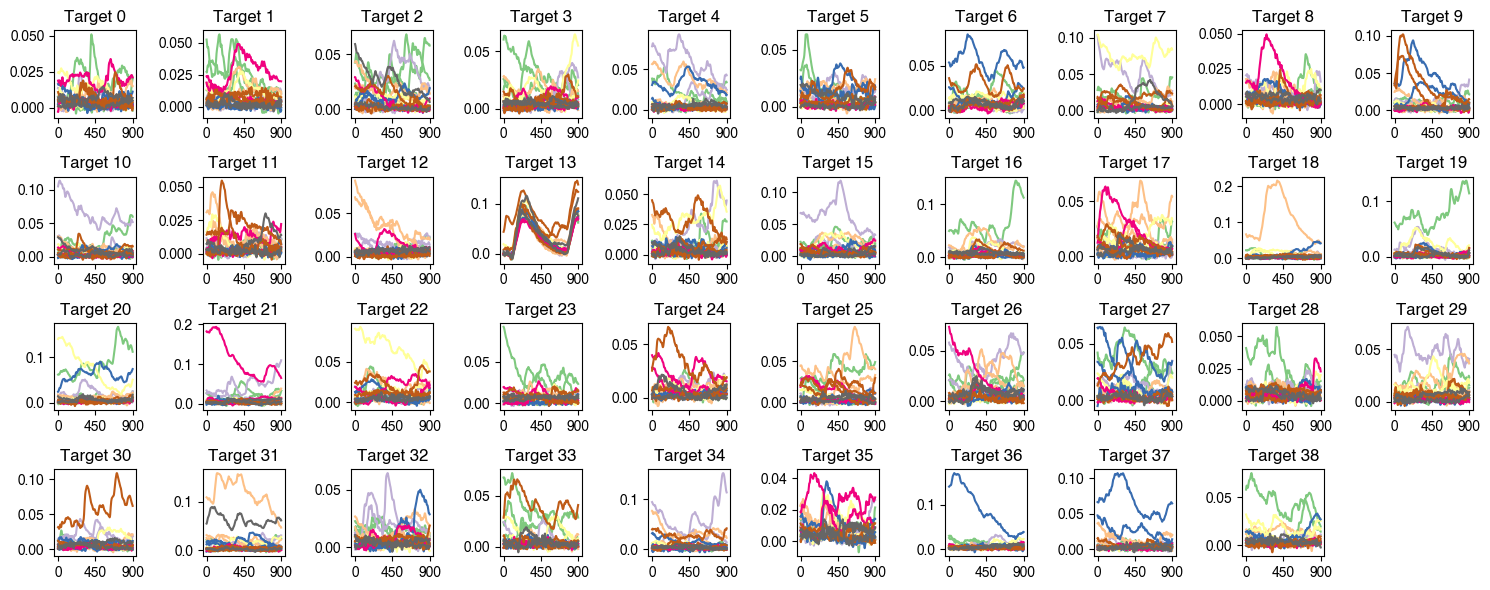

In [6]:
cmap = plt.get_cmap('Accent')
n_reps = np.where(stimulation_order == 0)[0].shape[0]

plt.figure(figsize=(ncols*panel_size, nrows*panel_size))
for n in range(N):
    locs = np.where(stimulation_order == n)[0]
    plt.subplot(nrows, ncols, n+1)
    
    # Plot each line with a color from the Accent colormap
    for i in range(n_reps):
        plt.plot(pscs[locs[i]], color=cmap(i / n_reps))

    plt.title('Target %i'%n)
    plt.xticks([0, 450, 900])
        
plt.tight_layout()
plt.show()

## Fit sum of PSC templates

In [7]:
n_kernels = 10 # number of PSC kernels/"templates" used
timepoints = np.linspace(-5, 40, 900) # ms
init_timepoints = np.linspace(timepoints[0], timepoints[-1], n_kernels) # PSC kernels initially equally spaced across the 45 ms trace
initial_guess = np.concatenate([[0.2, 0.3, 0.5, init_timepoints[i]] for i in range(n_kernels)]) # initial guess for the optimizer

In [8]:
# Define the cost function (sum of squared residuals)
def cost_function(params, timepoints, data, n_kernels):
    model_signal = sum_of_psc_templates(timepoints, params, n_kernels=n_kernels)
    return np.sum((model_signal - data) ** 2)

In [9]:
# Parameter bounds for the optimizer (formatted as a list of (min, max) tuples)
bounds = [(0.5, 10), (0.2, 10), (0.0, 5.0), (-7, 40)] * n_kernels
n_examples = 40

all_fitted_params = np.zeros((n_examples, n_kernels, 4))
reconstructed_traces = np.zeros((n_examples, T))

# Perform the fitting using minimize
for i in tqdm(range(n_examples)):
    # Perform the minimization for each example
    result = minimize(cost_function, initial_guess, args=(timepoints, pscs[i], n_kernels),
                      bounds=bounds, method='L-BFGS-B')
    
    # Extract the fitted parameters
    fitted_params = result.x.reshape(n_kernels, 4)
    all_fitted_params[i] = fitted_params
    
    # Reconstruct the traces using the fitted parameters
    reconstructed_traces[i] = sum_of_psc_templates(timepoints, result.x, n_kernels=n_kernels)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.25s/it]


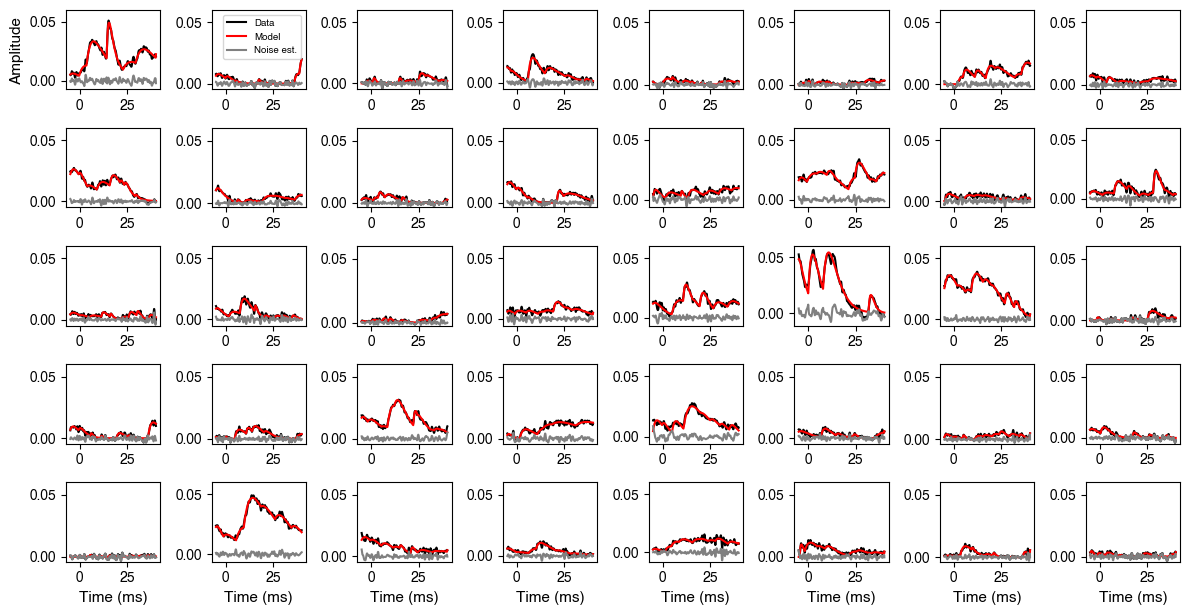

In [19]:
panel_width = 1.5
panel_height = 1.25
n_cols = 8
n_rows = int(np.ceil(n_examples/n_cols))

plt.figure(figsize=(n_cols * panel_width, n_rows * panel_height))
for i in range(n_examples): 
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(timepoints, pscs[i], color='k', label='Data')
    plt.plot(timepoints, reconstructed_traces[i], '-', color='r', label='Model')
    plt.plot(timepoints, pscs[i] - reconstructed_traces[i], color='gray', label='Noise est.')
    if i >= n_cols * (n_rows - 1):
        plt.xlabel('Time (ms)', fontsize=11)
    if i == 0:
        plt.ylabel('Amplitude', fontsize=11)
    plt.ylim(top=0.06)
    if i == 1:
        plt.legend(fontsize=7)
plt.tight_layout()
# plt.savefig('figs/paper/rebuttal/model_fit_to_in_vivo_pscs.png', format='png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

## Visualize distribution of PSC kernel parameters

In [11]:
_rise_times = all_fitted_params[:, :, 0].flatten()
_decay_times = all_fitted_params[:, :, 1].flatten() + all_fitted_params[:, :, 0].flatten()
_amplitudes = all_fitted_params[:, :, 2].flatten()
_latencies = all_fitted_params[:, :, 3].flatten()

In [12]:
# Only include parameters of kernels that are actually used
pos = np.where(_amplitudes > 1e-3)[0]

rise_times = _rise_times[pos]
decay_times = _decay_times[pos]
amplitudes = _amplitudes[pos]
latencies = _latencies[pos]

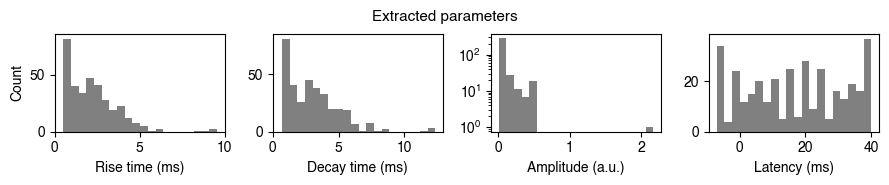

In [14]:
plt.figure(figsize=(9, 2.))

plt.subplot(1, 4, 1)
plt.hist(rise_times, 20, color='gray')
plt.ylabel('Count')
plt.xlabel('Rise time (ms)')
plt.xlim(left=0)

plt.subplot(1, 4, 2)
plt.hist(decay_times, 20, color='gray')
plt.xlabel('Decay time (ms)')
plt.xlim(left=0)

plt.subplot(1, 4, 3)
plt.hist(amplitudes, 20, color='gray')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Amplitude (a.u.)')

plt.subplot(1, 4, 4)
plt.hist(latencies, 20, color='gray')
plt.xlabel('Latency (ms)')

plt.suptitle('Extracted parameters', y=0.9, fontsize=11)
plt.tight_layout()

# plt.savefig('figs/paper/rebuttal/extracted_psc_parameter_distributions_in_vivo.png', format='png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()